## Assignment 1

### Task 1: Reading in the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
event_def = pd.read_csv("data/Event Definitions.csv")

In [3]:
event_def.sort_values(by='event_definition_id')

,event_name,journey_id,event_definition_id,milestone_number,stage
10,campaign_click,1,2,NaN,Discover
6,application_web_submit,1,3,NaN,Apply for Credit
21,browse_products,1,4,NaN,First Purchase
24,view_cart,1,5,NaN,First Purchase
20,begin_checkout,1,6,NaN,First Purchase
23,place_order_web,1,7,2.0,First Purchase
17,place_downpayment,1,8,4.0,Downpayment
11,customer_requested_catalog_digital,1,9,NaN,Discover
12,fingerhut_university,1,10,NaN,Discover
19,add_to_cart,1,11,NaN,First Purchase


In [4]:
df = pd.read_csv(
    "data/dat_train1.csv",
    low_memory=True,
    parse_dates=['event_timestamp'],
    usecols=['id', 'ed_id', 'event_name', 'event_timestamp', 'journey_steps_until_end'],
    dtype={
        'ed_id': np.uint8,
        'journey_steps_until_end': np.uint16
    }
)

In [5]:
df.dtypes

ed_id                                    uint8
event_name                              object
event_timestamp            datetime64[ns, UTC]
journey_steps_until_end                 uint16
id                                      object
dtype: object

In [6]:
df.head()

,ed_id,event_name,event_timestamp,journey_steps_until_end,id
0,4,browse_products,2021-11-04 14:11:15+00:00,1,15849251 383997507
1,4,browse_products,2021-11-04 14:11:29+00:00,2,15849251 383997507
2,4,browse_products,2021-11-04 14:12:10+00:00,3,15849251 383997507
3,4,browse_products,2021-11-04 14:12:21+00:00,4,15849251 383997507
4,4,browse_products,2021-11-04 14:12:24+00:00,5,15849251 383997507


In [7]:
df.shape

(54960961, 5)

In [8]:
df['id'].nunique()

1430445

In [9]:
df['event_timestamp'].min()

Timestamp('2020-11-03 03:31:30+0000', tz='UTC')

In [10]:
df['event_timestamp'].max()

Timestamp('2023-01-23 12:29:56+0000', tz='UTC')

1. The dataset has 54,960,961 rows.
2. There are 1,430,445 unique Ids in the dataset.
3. The earliest time stamp is `Timestamp('2020-11-03 03:31:30+0000', tz='UTC')` and the latest time stamp is `Timestamp('2023-01-23 12:29:56+0000', tz='UTC')`.

### Task 2: Remove Duplicates

In [11]:
num_duplicates = df.duplicated(
    subset=['id', 'ed_id', 'event_timestamp']
).sum()
print(f"There are {num_duplicates} duplicate rows, which is {num_duplicates / df.shape[0]} of all rows.")

There are 3112100 duplicate rows, which is 0.056623827956720045 of all rows.


In [12]:
df.drop_duplicates(
    subset=['id', 'ed_id', 'event_timestamp'],
    inplace=True
)

In [13]:
print(f"There are {df.shape[0]} rows after removing duplicates.")

There are 51848861 rows after removing duplicates.


1. 3,112,100 entries are duplicates, which makes up about 0.0566 of all rows.
2. After deleting duplicates, there are 51,848,861 in the data set.

Now let's recompute the `journey_steps_until_end` column, ensuring that the ordering of events within each journey is correct.

Each journey can be uniquely identified by its `id`.

In [14]:
df.sort_values(by=['id', 'event_timestamp'], inplace=True)
df['journey_steps_until_end'] = df.groupby('id').cumcount() + 1
df.reset_index(drop=True, inplace=True)

In [15]:
# Save the final data frame
df.to_csv("data/cleaned_dat_train1.csv", index=False)

Clear the cache and reload the new cleaned dataset

In [16]:
del df
import gc
gc.collect()

0

In [17]:
df = pd.read_csv(
    "data/cleaned_dat_train1.csv",
    low_memory=True,
    parse_dates=['event_timestamp'],
    usecols=['id', 'ed_id', 'event_name', 'event_timestamp', 'journey_steps_until_end'],
    dtype={
        'ed_id': np.uint8,
        'journey_steps_until_end': np.uint16
    }
)

## Task 5

We drop out repeated columns such as event name and the combined customer id and journey id as done above.

I will be using polars to deal with the data to enable lazy loading and parallel processing so it is not as painful to load the data...

Data will be stored as Parquet to allow for nested stuff like the journey

Refer to this: 

https://franzdiebold.github.io/polars-cheat-sheet/Polars_cheat_sheet.pdf

https://arrow.apache.org/docs/python/parquet.html

# Install these (or their conda equalivants, don't mix and match i suffered because of it)

pip install pyarrow

pip install polars

conda install -c conda-forge numpy pandas polars pyarrow matplotlib seaborn

In [18]:
import polars as pl

In [19]:
q = pl.scan_csv("data/cleaned_dat_train1.csv", try_parse_dates=True)

q = q.sort(["id", "event_timestamp"])

q = q.group_by("id").agg([
    pl.col("ed_id").alias("events"),
    pl.col("event_name").alias("event_names"),
    pl.col("event_timestamp").alias("timestamps"),
    pl.len().alias("journey_length")
])

q.sink_parquet("data/journeys_flattened.parquet")

In [20]:
# q = pl.scan_csv("data/cleaned_dat_train1.csv", try_parse_dates=True)

# q = q.sort(["customer_id", "account_id", "event_timestamp"])

# q = q.group_by(["customer_id", "account_id"]).agg([
#     pl.col("ed_id").alias("events"),
#     pl.col("event_timestamp").alias("timestamps"),
#     pl.len().alias("journey_length")
# ])

# q.sink_parquet("data/journeys_flattened.parquet")

Run future code from here:

In [2]:
df = pl.read_parquet("data/journeys_flattened.parquet")
print(df.head())

shape: (5, 5)
┌─────────────────────┬───────────────┬─────────────────────┬─────────────────────┬────────────────┐
│ id                  ┆ events        ┆ event_names         ┆ timestamps          ┆ journey_length │
│ ---                 ┆ ---           ┆ ---                 ┆ ---                 ┆ ---            │
│ str                 ┆ list[i64]     ┆ list[str]           ┆ list[datetime[μs,   ┆ u32            │
│                     ┆               ┆                     ┆ UTC]]               ┆                │
╞═════════════════════╪═══════════════╪═════════════════════╪═════════════════════╪════════════════╡
│ -1000001271         ┆ [12, 4, … 4]  ┆ ["application_web_a ┆ [2022-10-31         ┆ 7              │
│ 551641434           ┆               ┆ pproved", "…        ┆ 13:45:59 UTC, 2022… ┆                │
│ -100000293 92584960 ┆ [12, 4, … 1]  ┆ ["application_web_a ┆ [2021-11-11         ┆ 31             │
│                     ┆               ┆ pproved", "…        ┆ 01:30:43 UTC, 2

In [3]:
# Check if I did everything correctly

stats = df.select([
    pl.col("events").list.len().sum().alias("total_events"),
])
stats["total_events"][0]

51848861

Demo on adding order shipped as a new variable and total time

In [4]:
df = df.with_columns(
    order_shipped = pl.col("events").list.contains(28)
)
print(df.head())

shape: (5, 6)
┌────────────────┬───────────────┬────────────────┬────────────────┬───────────────┬───────────────┐
│ id             ┆ events        ┆ event_names    ┆ timestamps     ┆ journey_lengt ┆ order_shipped │
│ ---            ┆ ---           ┆ ---            ┆ ---            ┆ h             ┆ ---           │
│ str            ┆ list[i64]     ┆ list[str]      ┆ list[datetime[ ┆ ---           ┆ bool          │
│                ┆               ┆                ┆ μs, UTC]]      ┆ u32           ┆               │
╞════════════════╪═══════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╡
│ -1000001271    ┆ [12, 4, … 4]  ┆ ["application_ ┆ [2022-10-31    ┆ 7             ┆ false         │
│ 551641434      ┆               ┆ web_approved", ┆ 13:45:59 UTC,  ┆               ┆               │
│                ┆               ┆ "…             ┆ 2022…          ┆               ┆               │
│ -100000293     ┆ [12, 4, … 1]  ┆ ["application_ ┆ [2021-11-11    ┆ 31      

In [5]:
stats = df.select([
    pl.col("order_shipped").sum().alias("count_shipped"),
    pl.len().alias("total_journeys"),
    (pl.col("order_shipped").mean() * 100).alias("percentage_shipped")
])

print(stats)

shape: (1, 3)
┌───────────────┬────────────────┬────────────────────┐
│ count_shipped ┆ total_journeys ┆ percentage_shipped │
│ ---           ┆ ---            ┆ ---                │
│ u32           ┆ u32            ┆ f64                │
╞═══════════════╪════════════════╪════════════════════╡
│ 279363        ┆ 1430445        ┆ 19.529797          │
└───────────────┴────────────────┴────────────────────┘


In [6]:
df = df.with_columns(
    journey_duration = pl.col("timestamps").list.last() - pl.col("timestamps").list.first()
)

print(df.head())

# so we can plot the floats instead of duration type
df_plot = df.with_columns(
    duration_days = pl.col("journey_duration").dt.total_days()
)

shape: (5, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ id           ┆ events      ┆ event_names ┆ timestamps  ┆ journey_len ┆ order_shipp ┆ journey_dur │
│ ---          ┆ ---         ┆ ---         ┆ ---         ┆ gth         ┆ ed          ┆ ation       │
│ str          ┆ list[i64]   ┆ list[str]   ┆ list[dateti ┆ ---         ┆ ---         ┆ ---         │
│              ┆             ┆             ┆ me[μs,      ┆ u32         ┆ bool        ┆ duration[μs │
│              ┆             ┆             ┆ UTC]]       ┆             ┆             ┆ ]           │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ -1000001271  ┆ [12, 4, …   ┆ ["applicati ┆ [2022-10-31 ┆ 7           ┆ false       ┆ 33d 4h 47m  │
│ 551641434    ┆ 4]          ┆ on_web_appr ┆ 13:45:59    ┆             ┆             ┆ 28s         │
│              ┆             ┆ oved", "…   ┆ UTC, 2022…  ┆             ┆     

Plotting demo

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
import sys
print(sys.executable)

c:\Users\Ben\AppData\Local\anaconda3\envs\General\python.exe


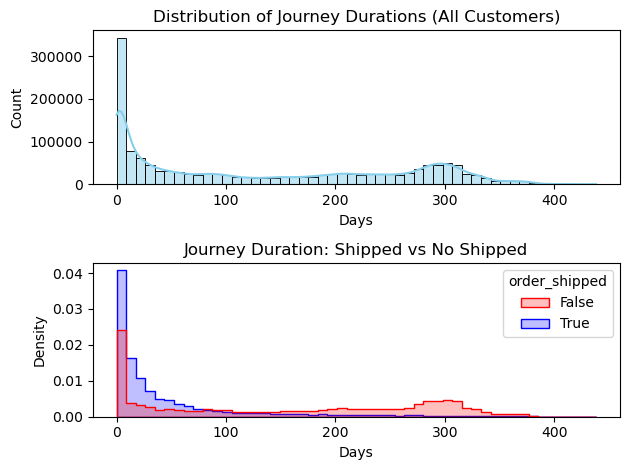

In [9]:
data_for_plot = df_plot.select(["duration_days", "order_shipped"]).to_pandas()

plt.subplot(2, 1, 1)
sns.histplot(data=data_for_plot, x="duration_days", bins=50, color="skyblue", kde=True)
plt.title("Distribution of Journey Durations (All Customers)")
plt.xlabel("Days")
plt.ylabel("Count")

plt.subplot(2, 1, 2)
sns.histplot(
    data=data_for_plot, 
    x="duration_days", 
    hue="order_shipped",
    element="step",
    stat="density",
    common_norm=False,
    palette={True: "blue", False: "red"},
    bins=50
)
plt.title("Journey Duration: Shipped vs No Shipped")
plt.xlabel("Days")
plt.ylabel("Density")

plt.tight_layout()
plt.show()

## Task 3

In [18]:
import pandas as pd
import numpy as np

df = pd.read_parquet("data/journeys_flattened.parquet")

In [19]:
df.shape

(1430445, 5)

In [20]:
df.head()

,id,events,event_names,timestamps,journey_length
0,-1000001271 551641434,"[12, 4, 19, 19, 19, 2, 4]","[application_web_approved, browse_products, ap...","[2022-10-31T13:45:59.000000, 2022-10-31T13:47:...",7
1,-100000293 92584960,"[12, 4, 4, 4, 4, 4, 4, 4, 11, 4, 4, 11, 4, 11,...","[application_web_approved, browse_products, br...","[2021-11-11T01:30:43.000000, 2021-11-11T01:39:...",31
2,-100001025 -1674572031,"[2, 19, 1, 19, 19, 19, 19, 19, 19, 19, 3, 19, ...","[campaign_click, application_web_view, promoti...","[2022-05-09T06:00:00.000000, 2022-05-09T13:10:...",26
3,-1000011207 -1448136887,"[12, 4, 11, 5, 5, 5, 4, 5, 4, 4, 4, 4, 1, 4, 4...","[application_web_approved, browse_products, ad...","[2021-03-21T11:19:48.000000, 2021-03-21T11:27:...",61
4,-100001164 -1710062169,[15],[application_phone_approved],[2022-12-02T07:45:16.000000],1


In [21]:
df['journey_length'].describe()

count    1.430445e+06
mean     3.624667e+01
std      4.175750e+01
min      1.000000e+00
25%      1.300000e+01
50%      2.400000e+01
75%      4.500000e+01
max      3.273000e+03
Name: journey_length, dtype: float64

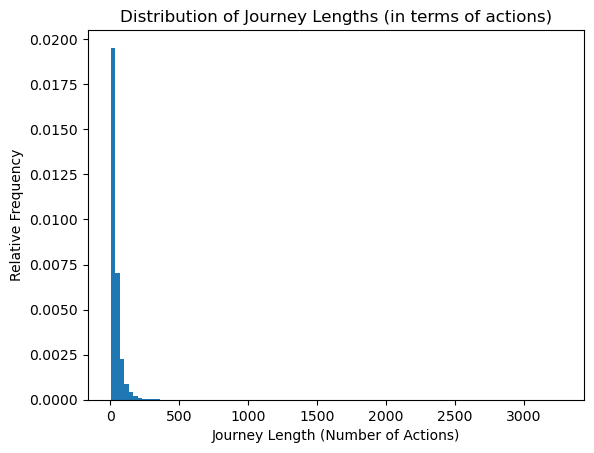

In [22]:
plt.hist(df['journey_length'], bins=100, density=True)
plt.title('Distribution of Journey Lengths (in terms of actions)')
plt.xlabel('Journey Length (Number of Actions)')
plt.ylabel('Relative Frequency')
plt.show()

In [23]:
journey_times = np.array([((timestamps[-1] - timestamps[0]) / np.timedelta64(1, 'D')).item() for timestamps in df['timestamps']])

In [24]:
journey_times.mean()

np.float64(133.6510021763252)

In [25]:
np.median(journey_times)

np.float64(98.04524305555556)

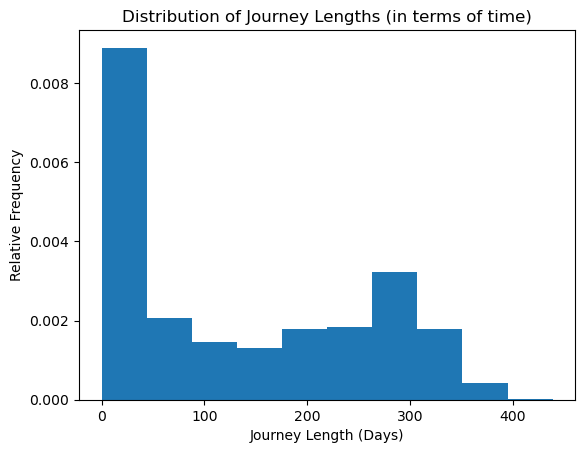

In [26]:
plt.hist(journey_times, density=True)
plt.title('Distribution of Journey Lengths (in terms of time)')
plt.xlabel('Journey Length (Days)')
plt.ylabel('Relative Frequency')
plt.show()

In [27]:
all_actions = []

for row in df.itertuples(index=False):
    all_actions.extend(row.event_names)

In [28]:
from collections import Counter

action_counts = Counter(all_actions)

In [29]:
action_counts.most_common(10)

[('browse_products', 19422197),
 ('view_cart', 5950083),
 ('application_web_view', 5860261),
 ('promotion_created', 5587608),
 ('add_to_cart', 3694835),
 ('begin_checkout', 2406324),
 ('catalog_(mail)', 2235308),
 ('application_web_approved', 1393357),
 ('campaignemail_clicked', 1377725),
 ('application_web_submit', 1176459)]

In [35]:
action_counts

Counter({'browse_products': 19422197,
         'view_cart': 5950083,
         'application_web_view': 5860261,
         'promotion_created': 5587608,
         'add_to_cart': 3694835,
         'begin_checkout': 2406324,
         'catalog_(mail)': 2235308,
         'application_web_approved': 1393357,
         'campaignemail_clicked': 1377725,
         'application_web_submit': 1176459,
         'campaign_click': 849847,
         'place_downpayment': 372910,
         'account_activitation': 357917,
         'place_order_web': 298160,
         'account_downpaymentcleared': 287417,
         'order_shipped': 279363,
         'pre-application_(3rd_party_affiliates)': 140792,
         'place_order_phone': 58851,
         'application_phone_approved': 37332,
         'application_web_declined': 36426,
         'site_registration': 16929,
         'account_downpaymentreceived': 7661,
         'application_phone_declined': 502,
         'catalog_(email)_(experian)': 435,
         'fingerhut_univ

In [30]:
action_time_differences = []

for row in df.itertuples(index=False):
    action_time_differences.extend(list(np.diff(row.timestamps) / np.timedelta64(1, 'D')))

In [31]:
action_time_differences = np.array(action_time_differences)

In [32]:
# Average number of days between actions
action_time_differences.mean()

np.float64(3.7918765200420648)

In [33]:
# Average number of minutes between actions
np.median(action_time_differences) * 24 * 60

np.float64(1.4666666666666666)

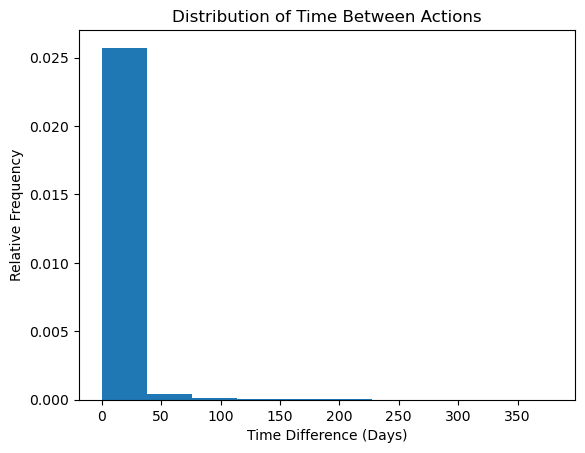

In [34]:
plt.hist(action_time_differences, density=True)
plt.title('Distribution of Time Between Actions')
plt.xlabel('Time Difference (Days)')
plt.ylabel('Relative Frequency')
plt.show()

In [46]:
df = pl.read_parquet("data/journeys_flattened.parquet")

In [47]:
df = df.with_columns([
    # did a promotion occur at all?
    pl.col("event_names").list.contains("promotion_created").alias("has_promo"),

    # index of first promotion (null if none)
    pl.col("event_names")
      .list.eval(pl.element().eq("promotion_created"))
      .list.arg_max()
      .alias("promo_index"),

    # journey length
    pl.col("event_names").list.len().alias("journey_length"),

    # order shipped = success
    pl.col("event_names").list.contains("order_shipped").alias("order_shipped"),

    # journey start / end
    pl.col("timestamps").list.first().alias("start_time"),
    pl.col("timestamps").list.last().alias("end_time"),
])


In [48]:
df = df.with_columns([
    # did a promotion occur at all?
    pl.col("event_names").list.contains("promotion_created").alias("has_promo"),

    # index of first promotion (null if none)
    pl.col("event_names")
      .list.eval(pl.element().eq("promotion_created"))
      .list.arg_max()
      .alias("promo_index"),

    # journey length
    pl.col("event_names").list.len().alias("journey_length"),

    # order shipped = success
    pl.col("event_names").list.contains("order_shipped").alias("order_shipped"),

    # journey start / end
    pl.col("timestamps").list.first().alias("start_time"),
    pl.col("timestamps").list.last().alias("end_time"),
])


In [49]:
df = df.with_columns(
    (pl.col("promo_index") / pl.col("journey_length"))
    .alias("promo_stage_frac")
)


In [50]:
promo_stage = (
    df.filter(pl.col("has_promo"))
      .select("promo_stage_frac")
      .to_pandas()
)


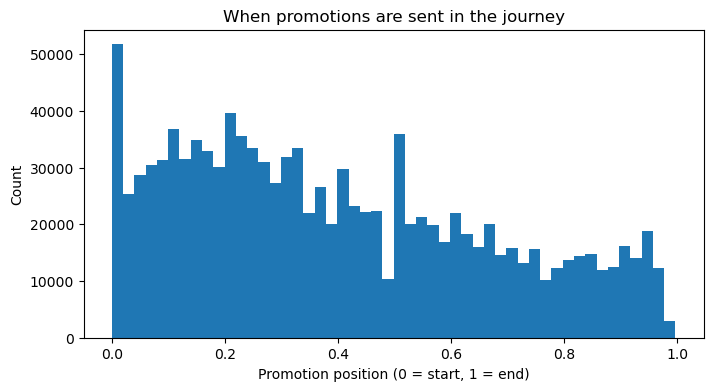

In [51]:
plt.figure(figsize=(8,4))
plt.hist(promo_stage["promo_stage_frac"], bins=50)
plt.xlabel("Promotion position (0 = start, 1 = end)")
plt.ylabel("Count")
plt.title("When promotions are sent in the journey")
plt.show()


In [52]:
df = df.with_columns(
    (pl.col("timestamps").list.get(pl.col("promo_index")) - pl.col("start_time"))
    .dt.total_days()
    .alias("days_to_promo")
)


In [53]:
promo_time = (
    df.filter(pl.col("has_promo"))
      .select("days_to_promo")
      .to_pandas()
)


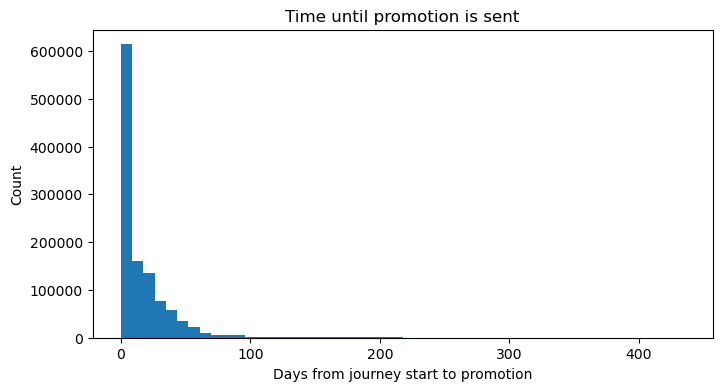

In [54]:
plt.figure(figsize=(8,4))
plt.hist(promo_time["days_to_promo"], bins=50)
plt.xlabel("Days from journey start to promotion")
plt.ylabel("Count")
plt.title("Time until promotion is sent")
plt.show()


In [55]:
promo_success = (
    df.select("has_promo", "order_shipped")
      .group_by("has_promo")
      .agg(pl.mean("order_shipped").alias("success_rate"))
      .to_pandas()
)


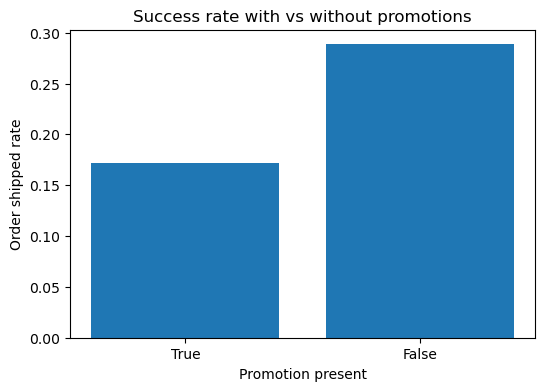

In [56]:
plt.figure(figsize=(6,4))
plt.bar(
    promo_success["has_promo"].astype(str),
    promo_success["success_rate"]
)
plt.xlabel("Promotion present")
plt.ylabel("Order shipped rate")
plt.title("Success rate with vs without promotions")
plt.show()


In [59]:
df = df.with_columns(
    pl.when(pl.col("promo_stage_frac") < 0.33)
      .then(pl.lit("early"))
      .when(pl.col("promo_stage_frac") < 0.66)
      .then(pl.lit("mid"))
      .otherwise(pl.lit("late"))
      .alias("promo_stage")
)

In [60]:
stage_success = (
    df.filter(pl.col("has_promo"))
      .group_by("promo_stage")
      .agg(pl.mean("order_shipped").alias("success_rate"))
      .to_pandas()
)


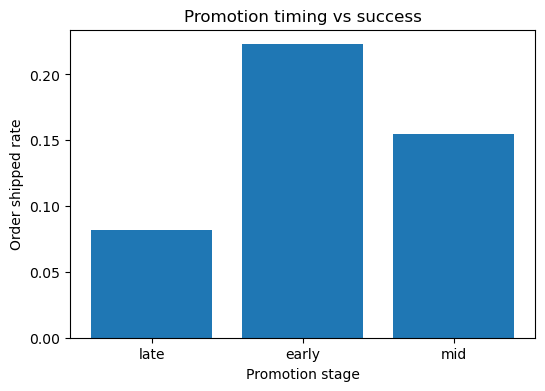

In [61]:
plt.figure(figsize=(6,4))
plt.bar(stage_success["promo_stage"], stage_success["success_rate"])
plt.xlabel("Promotion stage")
plt.ylabel("Order shipped rate")
plt.title("Promotion timing vs success")
plt.show()


In [62]:
df = df.with_columns(
    pl.col("journey_length").cut([5, 10, 20, 50], labels=["very short","short","medium","long","very long"])
    .alias("journey_bucket")
)


In [63]:
bucket_success = (
    df.group_by("journey_bucket", "has_promo")
      .agg(pl.mean("order_shipped").alias("success_rate"))
      .to_pandas()
)


In [65]:
bucket_order = ["very short", "short", "medium", "long", "very long"]

bucket_success["journey_bucket"] = pd.Categorical(
    bucket_success["journey_bucket"],
    categories=bucket_order,
    ordered=True
)

bucket_success = bucket_success.sort_values("journey_bucket")


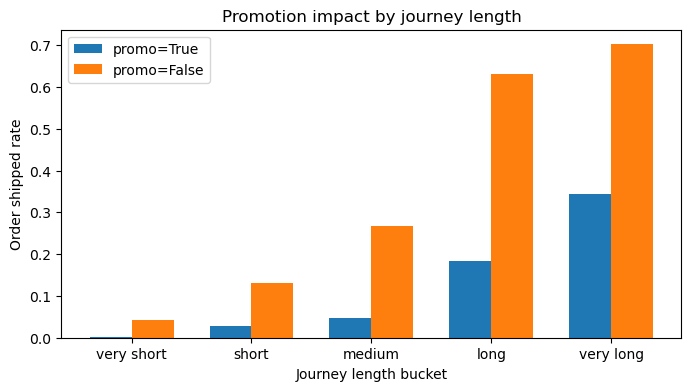

In [66]:
import numpy as np

x = np.arange(len(bucket_order))
width = 0.35

promo = bucket_success[bucket_success["has_promo"] == True]
no_promo = bucket_success[bucket_success["has_promo"] == False]

plt.figure(figsize=(8,4))
plt.bar(x - width/2, promo["success_rate"], width, label="promo=True")
plt.bar(x + width/2, no_promo["success_rate"], width, label="promo=False")

plt.xticks(x, bucket_order)
plt.xlabel("Journey length bucket")
plt.ylabel("Order shipped rate")
plt.title("Promotion impact by journey length")
plt.legend()
plt.show()
